In [1]:
from utils import import_train_data
df, test_df = import_train_data()
df.sample(10)

,image_path,category,target,r
82,data/숫자인식/00/r_n00/4d_r_n00_33.jpg,number,0,True
3515,data/알파벳인식/Y/r_Y/4d_al_r_Y_45.jpg,alphabet,Y,True
76,data/숫자인식/00/r_n00/4d_r_n00_27.jpg,number,0,True
3304,data/알파벳인식/W/r_W/4d_al_r_W_34.jpg,alphabet,W,True
2404,data/알파벳인식/N/r_N/4d_al_r_N_34.jpg,alphabet,N,True
566,data/숫자인식/05/r_n05/4d_r_n05_16.jpg,number,5,True
1686,data/알파벳인식/G/r_G/4d_al_r_G_26.jpg,alphabet,G,True
1543,data/알파벳인식/F/F/4d_al_F_43.jpg,alphabet,F,False
1180,data/알파벳인식/B/r_B/4d_al_r_b_30.jpg,alphabet,B,True
1744,data/알파벳인식/H/H/4d_al_H_34.jpg,alphabet,H,False


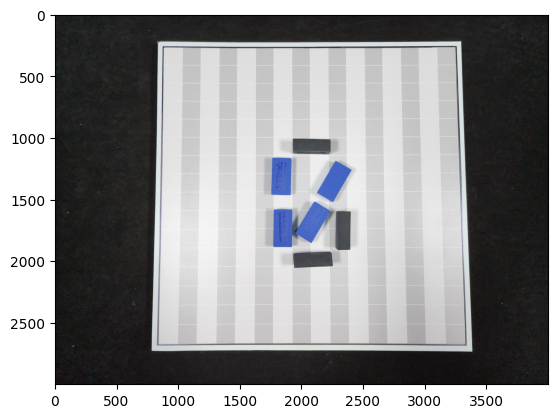

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread(df.sample(1)['image_path'].values[0])
plt.imshow(img)

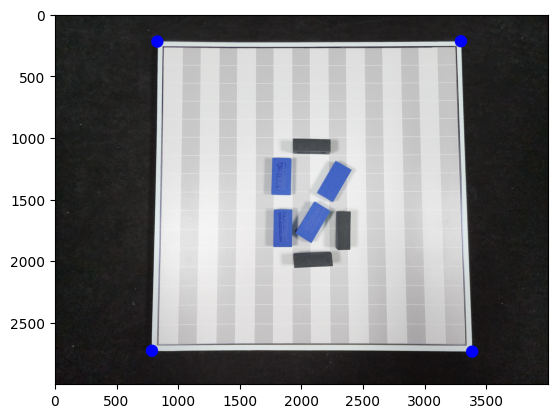

In [3]:
from preprocessing import get_board_corners, sort_vertices

corners = get_board_corners(img)
h, w, _ = img.shape
origin_points = sort_vertices(corners, h, w)

# visualize origin points
img_points = img.copy()
for p in origin_points:
    x, y = int(p[0]), int(p[1])
    cv2.circle(img_points, (x, y), 50, (0, 0, 255), -1)

plt.imshow(img_points)

In [4]:
dest_points = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]])
perspective_matrix = cv2.getPerspectiveTransform(origin_points, dest_points)
perspective_matrix

array([[ 1.64005002e+00,  2.87842844e-02, -1.36766041e+03],
       [ 1.54630921e-03,  1.26951986e+00, -2.84386365e+02],
       [ 1.59698944e-06,  2.19674939e-05,  1.00000000e+00]])

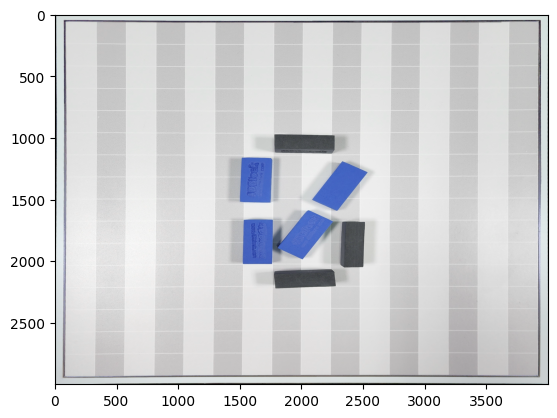

In [5]:
warped_img = cv2.warpPerspective(img, perspective_matrix, (w, h))
plt.imshow(warped_img)

In [6]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (w, h))

animation_duration_sec = 2
frame_rate = 24

total_frames = int(animation_duration_sec * frame_rate)

initial_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
final_matrix = perspective_matrix

for frame_number in range(total_frames):
    interpolation_factor = frame_number / (total_frames - 1)

    matrix = (1 - interpolation_factor) * initial_matrix + interpolation_factor * final_matrix

    output_image = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))

    out.write(output_image)

out.release()

In [10]:
from preprocessing import get_masks, warp_image, warp_to_board, mask_square

def get_perspective_matrix(img):
    corners = get_board_corners(img)
    h, w, _ = img.shape
    origin_points = sort_vertices(corners, h, w)
    dest_points = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]])
    perspective_matrix = cv2.getPerspectiveTransform(origin_points, dest_points)
    return perspective_matrix

def gen_transform_video(img, output_path):
    h, w, _ = img.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (w, h))

    animation_duration_sec = 1
    frame_rate = 24

    total_frames = int(animation_duration_sec * frame_rate)

    initial_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
    final_matrix = get_perspective_matrix(img)

    for frame_number in range(total_frames):
        interpolation_factor = frame_number / (total_frames - 1)

        matrix = (1 - interpolation_factor) * initial_matrix + interpolation_factor * final_matrix

        output_image = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))

        out.write(output_image)

    img = warp_to_board(img)

    main, gray = get_masks(img)
    

    border = np.zeros_like(main)
    margin = int(w * 0.05)
    border[margin:-margin, margin:-margin] = 255

    main = cv2.bitwise_and(main, main, mask=border)
    main = cv2.dilate(main, (5, 5), iterations=3)

    gray = cv2.bitwise_and(gray, gray, mask=border)
    gray = cv2.dilate(gray, (5, 5), iterations=3)

    target_image = np.zeros_like(img)
    target_image[main == 255] = (0, 165, 255)
    target_image[gray == 255] = (255, 0, 0)

    # make main 3d
    #main = np.stack((main,)*3, axis=-1)

    # transition to target_image 
    for frame_number in range(total_frames):
        interpolation_factor = frame_number / (total_frames - 1)

        interpolated_image = cv2.addWeighted(img, 1 - interpolation_factor, target_image, interpolation_factor, 0)

        out.write(interpolated_image)
    
    # wait 1 sec on the target image
    for frame_number in range(frame_rate):
        out.write(target_image)

    out.release()

img = cv2.imread(df.sample(1)['image_path'].values[0])
gen_transform_video(img, 'output.mp4')

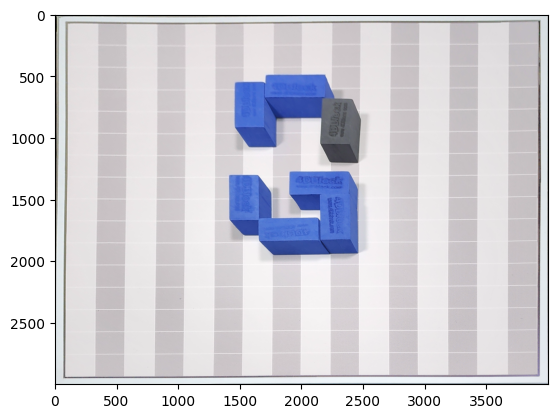

In [44]:
from preprocessing import warp_to_board
img = cv2.imread(df.sample(1)['image_path'].values[0])
img = warp_to_board(img)
plt.imshow(img)

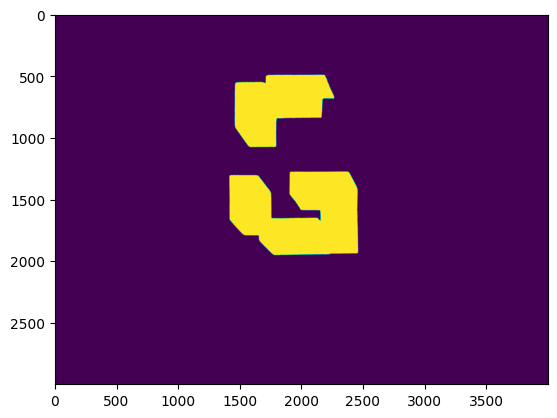

In [45]:
main, gray = get_masks(img)
border = np.zeros_like(main)
margin = int(w * 0.05)
border[margin:-margin, margin:-margin] = 255
main = cv2.bitwise_and(main, main, mask=border)
plt.imshow(main)

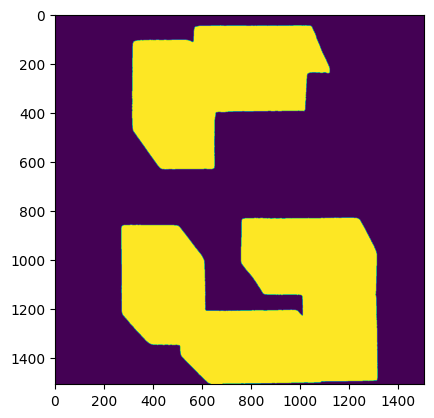

In [46]:
from preprocessing import mask_square
square_main = mask_square(main)
plt.imshow(square_main)

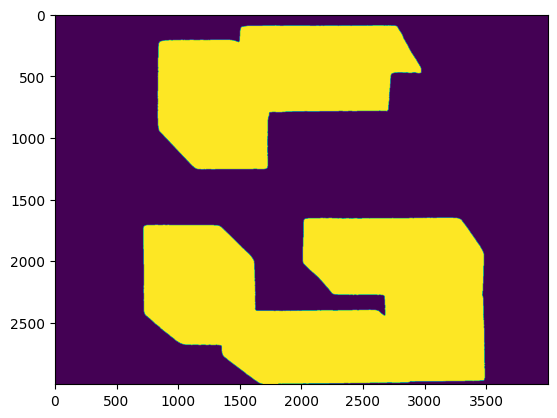

In [48]:
square_main = cv2.resize(square_main, (4000, 3000))
plt.imshow(square_main)

In [51]:
square_main = np.stack((square_main,)*3, axis=-1)
square_main.shape

(3000, 4000, 3)